# Sutton 
 
## Chapter 2 - Evaluative Feedback

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import numpy.random 

**Ex 2.1**
In the long run, $\epsilon$=0.01 will perform the best as it will eventually converge to the true probabilities, but will spend less time exploring when it does.  It is likely to be approximately 9% better than $\epsilon$=0.10 once it hits convergence.

**Ex 2.2** Experimentation with e-greedy and softmax methods for solving n-bandit problem.


In [3]:
# First some helper functions

class NB_Base:
        
    def __init__(self, n, reward_mean = None, reward_std = None):
        """ Initialize the n-bandit.  If reward-mean and reward_std are not provided expected rewards will 
            be initialized to values taken from a standard normal distribution.
        """
        self.n = n
        self._reward_mean = reward_mean if reward_mean else [random.normalvariate(0, 1) for x in range(n)]
        self._reward_std = reward_std if reward_std else [1.0] * n
        
        self.reward_decay = 1.0  # gamma
        self.random_walk = 0.0   # if non zero moves reward means
        
        self._reset()
        
    def _reset(self):
        self.ev = [0.0] * self.n 
        self.total_value = [0.0] * self.n 
        self.num_trys = [0] * self.n
        self._score = 0
    
    def choose(self, x):
        
        # perform selection
        reward = random.normalvariate(self._reward_mean[x], self._reward_std[x])
        self._score += reward
        self.num_trys[x] += 1
        self.total_value[x] += reward
        self.ev[x] = self.total_value[x] / self.num_trys[x]
        
        # decay the expected value
        if (self.reward_decay != 1.0):
            for i in range(self.n):
                self.total_value[i] = self.total_value[i] * self.reward_decay 
                self.ev[i] = self.total_value[i] / self.num_trys[i] if self.num_trys[i] != 0 else 0
            
        # random walk
        if (self.random_walk != 0.0):
            for i in range(self.n):
                self._reward_mean[i] = self._reward_mean[i] + random.normalvariate(0, self.random_walk)
                
        
        
    def step(self):
        raise exception("Please overwrite step function.")
        
    def run(self, iterations = 1000):
        """ Runs [iterations] steps in the simulation and returns score history, and choice history. """
        score_history = []
        choice_history = []
        for i in range(iterations):
            score_history.append(self._score)
            selected = self.step()
            choice_history.append(selected)
            self.choose(selected)
        return (score_history, choice_history)
    

class NB_Epsilon_Greedy(NB_Base):
    
    def __init__(self, n, epsilon, reward_mean = None, reward_std = None):
        super().__init__(n, reward_mean, reward_std)
        self.epsilon = epsilon
        
    def step(self):        
        best = np.argmax(self.ev)

        if (random.random() < self.epsilon):
            # explore
            return random.choice(list(range(0, best)) + list(range(best+1, self.n)))
        else:
            # exploit
            return best

        
class NB_Softmax(NB_Base):
    
    def __init__(self, n, tau, reward_mean = None, reward_std = None):
        super().__init__(n, reward_mean, reward_std)
        self.tau = tau
        
    def step(self):        
        exp_x = np.exp([(x / self.tau) for x in self.ev])
        weights = exp_x / np.sum(exp_x)
        selection = np.random.choice(range(self.n), 1, p=weights)        
        return selection[0]


In [4]:
def evaluate(algo, samples = 2000, steps = 1000):
    """ Evaluate the algorithm, returning tupple (avg_score, optimal_select_percent)"""
    
    avg_score = [0] * steps
    optimal_select_percent = [0] * steps
    
    for i in range(samples):
        algo._reset()
        algo._reward_mean = [random.normalvariate(0, 1) for x in range(algo.n)]
        best_choice = np.argmax(algo._reward_mean)
        score_history, choice_history = algo.run(steps)
        for j in range(len(score_history)):        
            avg_score[j] += score_history[j] / samples
            optimal_select_percent[j] += (1.0 if choice_history[j] == best_choice else 0.0) / samples
            
    return avg_score, optimal_select_percent

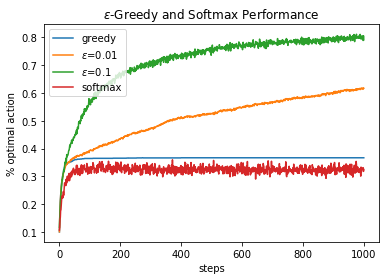

In [5]:
_, result = evaluate(NB_Epsilon_Greedy(10, epsilon = 0))
plt.plot(result, label="greedy")

_, result = evaluate(NB_Epsilon_Greedy(10, epsilon = 0.01))
plt.plot(result, label="$\epsilon$=0.01")

_, result = evaluate(NB_Epsilon_Greedy(10, epsilon = 0.1))
plt.plot(result, label="$\epsilon$=0.1")

_, result = evaluate(NB_Softmax(10, tau = 1.0))
plt.plot(result, label="softmax")

plt.xlabel("steps")
plt.ylabel("% optimal action")
plt.legend()

plt.title("$\epsilon$-Greedy and Softmax Performance")
plt.show()
                

The softmax function performs very poorly.  We will try adjusting the $\tau$ parameter to see if that can improve its peformance.

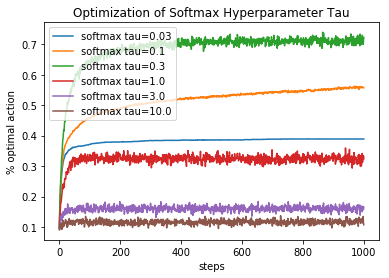

In [6]:
_, result = evaluate(NB_Softmax(10, tau = 0.03))
plt.plot(result, label="softmax tau=0.03")

_, result = evaluate(NB_Softmax(10, tau = 0.1))
plt.plot(result, label="softmax tau=0.1")

_, result = evaluate(NB_Softmax(10, tau = 0.3))
plt.plot(result, label="softmax tau=0.3")

_, result = evaluate(NB_Softmax(10, tau = 1.0))
plt.plot(result, label="softmax tau=1.0")

_, result = evaluate(NB_Softmax(10, tau = 3.0))
plt.plot(result, label="softmax tau=3.0")

_, result = evaluate(NB_Softmax(10, tau = 10.0))
plt.plot(result, label="softmax tau=10.0")

plt.xlabel("steps")
plt.ylabel("% optimal action")
plt.legend()

plt.title("Optimization of Softmax Hyperparameter Tau")
plt.show()        

The optimal value for $\tau$ is 0.3 
Let us compare this to the $\epsilon$=0.1 and $\epsilon$=0.01 algorithm over a long peroid.

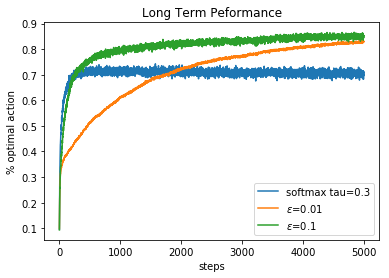

In [7]:
_, result = evaluate(NB_Softmax(10, tau = 0.3), steps = 5000)
plt.plot(result, label="softmax tau=0.3")

_, result = evaluate(NB_Epsilon_Greedy(10, epsilon = 0.01), steps = 5000)
plt.plot(result, label="$\epsilon$=0.01")

_, result = evaluate(NB_Epsilon_Greedy(10, epsilon = 0.1), steps = 5000)
plt.plot(result, label="$\epsilon$=0.1")

plt.xlabel("steps")
plt.ylabel("% optimal action")
plt.legend()

plt.title("Long Term Peformance")
plt.show()
               

Although the softmax function is slightly faster,  the $\epsilon$-greedy algorithms converge nicely over the long term to a higher performance (~90%, as compared to ~70%)

**Ex 2.3**

The Gibbs equation for two actions gives

\begin{equation}
\frac{e^{Q_1/\tau}}{e^{Q_1/\tau}+e^{Q_2/\tau}}
\Rightarrow
\frac{1}{1+e^{\frac{Q_2-Q_1}{\tau}}} 
\end{equation}

Which is the logistic function on $\frac{Q_2-Q_1}{\tau}$. That is the difference between the two actions scores.  $\tau$ acts to scale this difference to either exaggerate it (for high $\tau$), or diminish it (for low $\tau$).


**Ex 2.4**
The idea here is to simply pick the correct class if p < 0.5 and the incorrect one if p > 0.5

**Ex 2.5**
See code above 

**Ex 2.6**
$\Sigma \alpha_i (1-\alpha)^{k-i}r_i$

** Ex 2.7 **
Demonstrate the difficulties that the sample-average methods have for nonstationary problems.

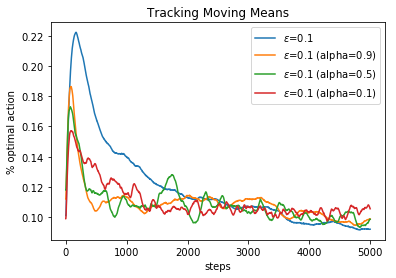

In [12]:
def evaluate_random_walk(algo, reward_decay = 1.0):        
    algo.random_walk = 0.3
    algo.reward_decay = reward_decay
    algo._reward_mean = [0.0] * algo.n
    _, result = evaluate(algo, samples = 1000, steps = 5000)
    return result

def smooth(data, factor = 0.99):
    result = []
    c = data[0]
    for x in data:
        result.append(c)
        c = c * factor + (1-factor) * x
    return result
        
    
result = evaluate_random_walk(NB_Epsilon_Greedy(10, epsilon = 0.1), reward_decay = 1.0)
result = smooth(result)
plt.plot(result, label="$\epsilon$=0.1")

result = evaluate_random_walk(NB_Epsilon_Greedy(10, epsilon = 0.1), reward_decay = 0.9)
result = smooth(result)
plt.plot(result, label="$\epsilon$=0.1 (alpha=0.9)")

result = evaluate_random_walk(NB_Epsilon_Greedy(10, epsilon = 0.1), reward_decay = 0.5)
result = smooth(result)
plt.plot(result, label="$\epsilon$=0.1 (alpha=0.5)")

result = evaluate_random_walk(NB_Epsilon_Greedy(10, epsilon = 0.1), reward_decay = 0.1)
result = smooth(result)
plt.plot(result, label="$\epsilon$=0.1 (alpha=0.1)")

plt.xlabel("steps")
plt.ylabel("% optimal action")
plt.legend()

plt.title("Tracking Moving Means")
plt.show()


Many iterations are required before the reward decay algorithm outperforms the standard $\epsilon$-greedy algorithm.  We see at around iterations 3500 the reward decal algorithm $\alpha$=0.1 starts perform better.  This is because it is able to better 'forget' the previous best actions, and adapt to the changing means.

**Ex 2.8**
The optimistic greedy algorithm starts with a very optimistic evaluation of each action.  One by one, these actions will be tried until their true value falls.  At some point, the algorithm will by trying the correct action (even though it doesn't know it) and this will cause a spike early on.

**Ex 2.9**
This is the same as scaling the rewards, so no flexiability has been lost.